# Aggregating Census Data to Custom Geographies

In this notebook, you'll see how to use Python and Census Bureau APIs to aggregate Census data for custom geographies.  For this exercise, we'll aggregate the total population for [Chicago's 77 community areas](https://en.wikipedia.org/wiki/Community_areas_in_Chicago). Hopefully, you'll see how you could adapt this for your own geographies and other data which is available from the Census API.

This notebook is short on technical explanation. If you're not clear about some details, you may want to consult official documentation for some of the key libraries used:

* [cenpy](https://cenpy-devs.github.io/cenpy/)
* [pandas](https://pandas.pydata.org/pandas-docs/stable/)
* [geopandas](http://geopandas.org/)
* [matplotlib](https://matplotlib.org/index.html)



## Introducing Cenpy

[`Cenpy`](https://cenpy-devs.github.io/cenpy/) is a fairly new, rapidly evolving Python library for working with Census data. There are others, but I like the potential of `cenpy`'s "products" API, which reduces the friction for one of the most common tasks people want to do, which is to request data for geographies contained within another geography, such as "get me all of the Census tracts in Chicago."  

It takes a bit of time to execute (seconds not minutes), because the one python function call (`from_place()`) is making at least a few Census API calls, first to interpret the place name, then to get the geographies, and then to get the data.  But once it's done, it's all given back to you in a handy [GeoPandas](http://geopandas.org/) data frame, which makes the mapping really easy.

In [1]:
import cenpy
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
%matplotlib inline

# Without an API Key, the Census API is limited to 500 daily requests per IP address. 
# I've obtained an API key for use with this exercise, but it may be disabled at any time. If you have your own, use it below, and if you get an error using this one, 
# you may need to request your own key
# see https://www.census.gov/data/developers/guidance/api-user-guide.Query_Components.html for more about limits and a link to request your own key. 
# There's usually a short wait before keys are issued
CENSUS_API_KEY = '6871e29db5145699fdcbbd7da64b3eb9e49c25d4'


dlopen(/usr/local/lib/gdalplugins/gdal_MrSID.dylib, 1): Symbol not found: __ZN14GDALRasterBand23GetRasterSampleOverviewEi
  Referenced from: /usr/local/lib/gdalplugins/gdal_MrSID.dylib
  Expected in: flat namespace
 in /usr/local/lib/gdalplugins/gdal_MrSID.dylib
dlopen(/usr/local/lib/gdalplugins/gdal_MrSID.dylib, 1): Symbol not found: __ZN14GDALRasterBand23GetRasterSampleOverviewEi
  Referenced from: /usr/local/lib/gdalplugins/gdal_MrSID.dylib
  Expected in: flat namespace
 in /usr/local/lib/gdalplugins/gdal_MrSID.dylib
dlopen(/usr/local/lib/gdalplugins/gdal_MG4Lidar.dylib, 1): Symbol not found: __ZN11GDALDataset9IRasterIOE10GDALRWFlagiiiiPvii12GDALDataTypeiPiiii
  Referenced from: /usr/local/lib/gdalplugins/gdal_MG4Lidar.dylib
  Expected in: flat namespace
 in /usr/local/lib/gdalplugins/gdal_MG4Lidar.dylib
dlopen(/usr/local/lib/gdalplugins/gdal_MG4Lidar.dylib, 1): Symbol not found: __ZN11GDALDataset9IRasterIOE10GDALRWFlagiiiiPvii12GDALDataTypeiPiiii
  Referenced from: /usr/local/lib/g

Matched: Chicago, IL to Chicago city within layer Incorporated Places


/Users/germuska/Library/Caches/pypoetry/virtualenvs/nicar-2020-advanced-census-EPhDb8iA-py3.7/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


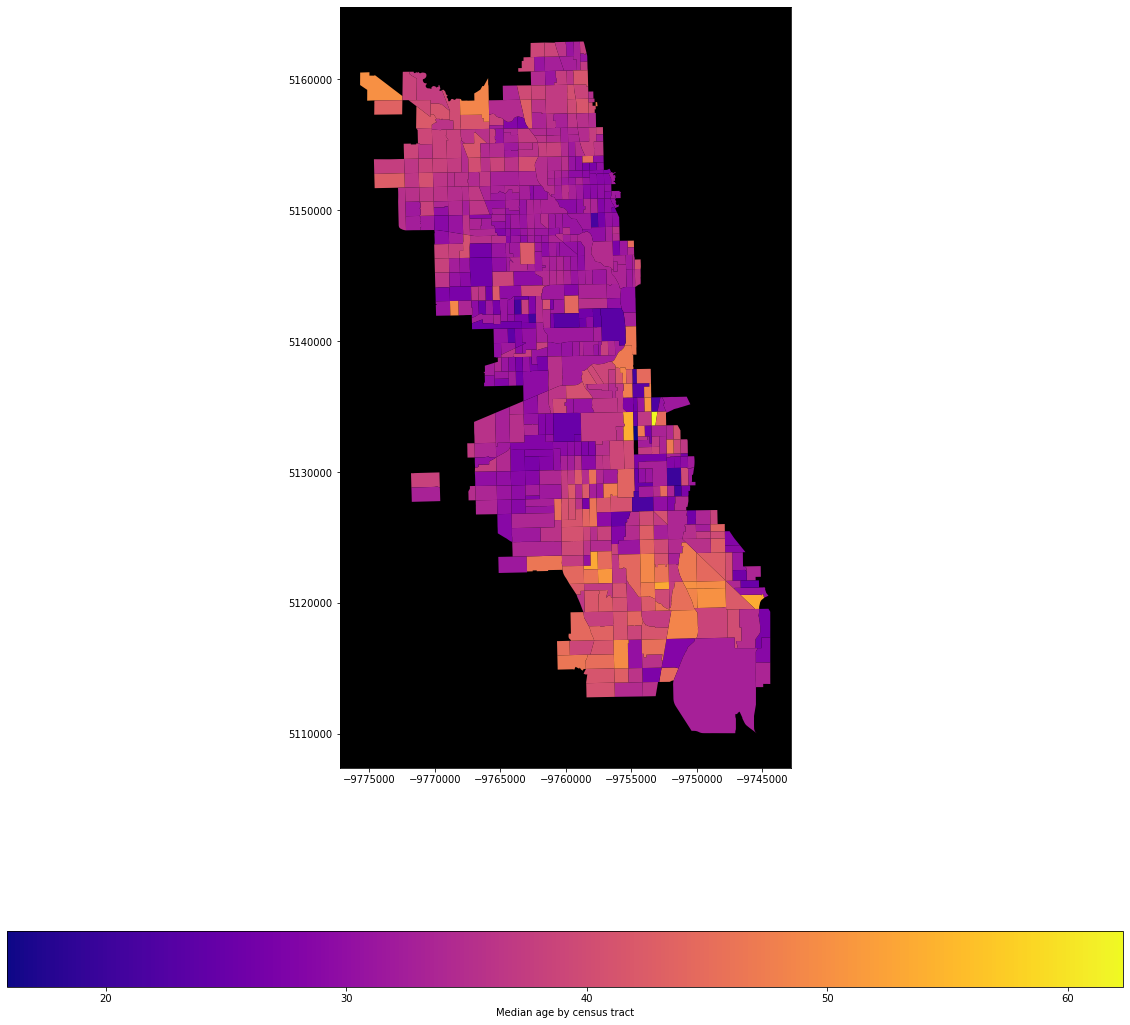

In [2]:
# This is lightly adapted from one of Cenpy's demonstration notebooks
chi_median_age = cenpy.products.ACS(2018).from_place('Chicago, IL', level='tract',
                                        variables=['B01002_001E'])

# Internet troubles? comment out the line above, and uncomment the next line
# chi_median_age = geopandas.read_file('data/chi_median_age.geojson')

f, ax = plt.subplots(1,1,figsize=(20,20)) # make a bigger map than the default
chi_median_age.dropna(subset=['B01002_001E'], axis=0).plot('B01002_001E', 
                                                    ax=ax, 
                                                    cmap='plasma', 
                                                    legend=True, 
                                                    legend_kwds={
                                                        'label': "Median age by census tract",
                                                        'orientation': "horizontal"
                                                    })
ax.set_facecolor('k')

### However...

People used to working with Chicago maps may notice something strange about the map above. It doesn't show O'Hare airport, which should be at the top left of the map. 

It turns out that the City of Chicago publishes an ["official" list of Census tracts](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Tracts-2010/5jrd-6zik).  Let's look at the difference.

/Users/germuska/Library/Caches/pypoetry/virtualenvs/nicar-2020-advanced-census-EPhDb8iA-py3.7/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


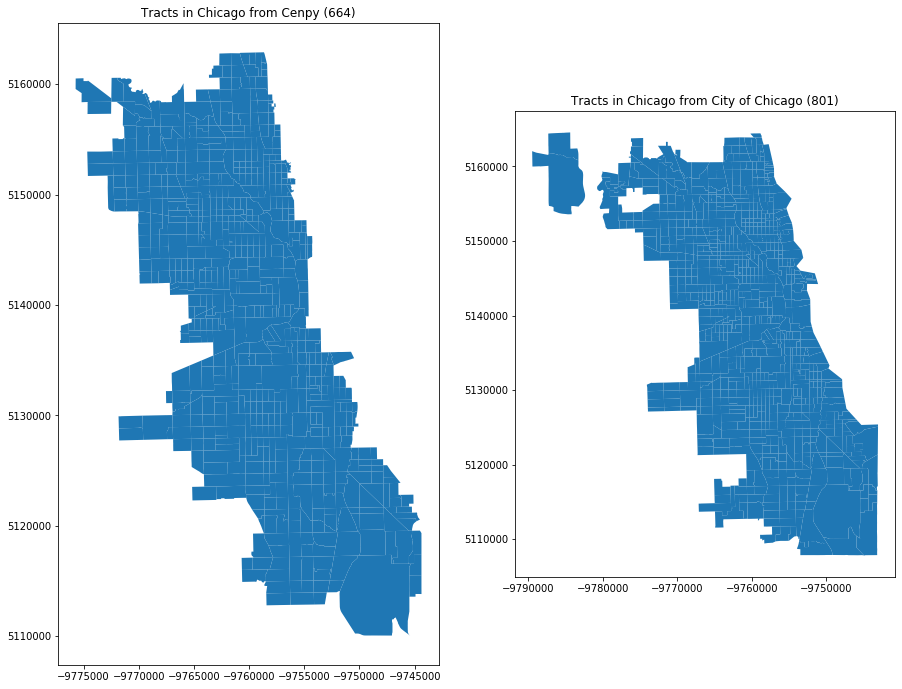

In [4]:
chi_tracts = geopandas.read_file('data/Boundaries - Census Tracts - 2010.geojson')
chi_tracts = chi_tracts.to_crs(chi_median_age.geometry.crs) # make them the same projection
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.set_title(f'Tracts in Chicago from Cenpy ({len(chi_median_age)})')
ax2.set_title(f'Tracts in Chicago from City of Chicago ({len(chi_tracts)})')
chi_median_age.plot(ax=ax1)
chi_tracts.plot(ax=ax2)

#### Just because we can...

let's see just the tracts that are missing from the `cenpy` query.  (Computing the population of just these missing tracts is left as an exercise for the reader!)

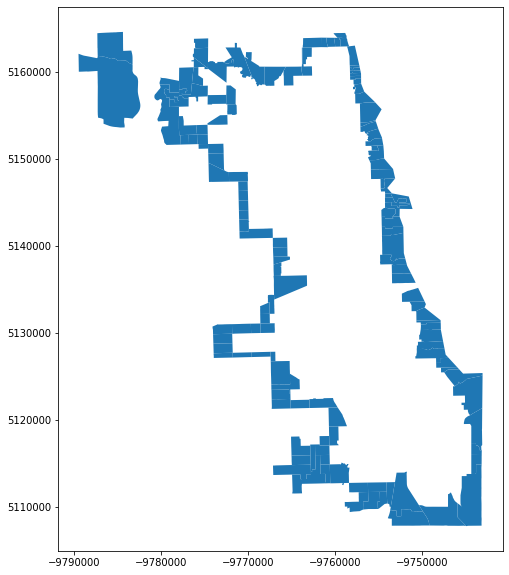

In [5]:
f, ax = plt.subplots(1,1,figsize=(10,10))
missing = chi_tracts[~chi_tracts['geoid10'].isin(chi_median_age['GEOID'])] # ~ is the "inverse" operator in panda
missing.plot(ax=ax)

### So what do we do about it?

If you talk to me about Census data for long, you'll get me going on this topic. It's way harder than it ought to be to know "officially" which Census tracts are in a given Census "place".  One reason for that is that place boundaries can cut through tracts, so any official resource would have to deal with partial tracts, and how to allocate estimates for the tract into the parts, etc.

Maybe you don't need perfect precision.  Or maybe, like in this case, you can find an authoritative list for your needs.

(I do have one weird trick for generating a reliable list of tracts that are in, or partly in a given Census place, as well as several other geographies, [using the LODES LEHD crosswalk files](https://lehd.ces.census.gov/data/lodes/LODES7). It's not too bad to do on a case-by-case basis. Ask me if you want to know more. Maybe soon I can make another notebook about it.)

If you *can* use `cenpy.products`, the nice thing is that one request gets you data and geographic coordinates. But never fear, you can do those steps yourself. It's a little more work, but this notebook will show you how.  


## Getting the data

To do it yourself, you need to identify the Census Bureau data product and the variables within it for your purposes. You can browse through [a page on the Census site](https://api.census.gov/data.html) to know basically what's available, but `cenpy` uses its own system of codes to identify products -- plus, maybe you like to use Python methods to filter the long list of products down to what you need.

### Cenpy's `explorer` tools



As mentioned above, `cenpy` is new, and evolving quickly. In addition to the place-in-place queries, `cenpy.products` tries to present a simple API for exploring available data tables and variables, but in developing this notebook, it seemed as though many of those features were unreliable. No doubt that will get better, especially if folks like us who use the library participate in its development.  But for now, we'll use the "old fashioned" way to explore the data.

**Remember**: It's always best to read official documentation to make sure you're not assuming anything -- but even when you have, these kinds of tools can come in handy.

In [6]:
# `cenpy.explorer.available()` function returns a Pandas data frame with high level information about what the Census API serves.  
# but it's a real big data frame
avail = cenpy.explorer.available()
print(f"The API offers access to {len(avail)} datasets") # how big?
avail.head() # so let's just peek. The index column (unlabeled, but at the leftmost position) is the cenpy code you'll need to work with that data product.

The API offers access to 411 datasets


,c_isTimeseries,c_isCube,publisher,temporal,spatial,programCode,modified,keyword,contactPoint,distribution,...,c_isAvailable,c_isAggregate,c_valuesLink,c_groupsLink,c_examplesLink,c_tagsLink,c_variablesLink,c_geographyLink,c_dataset,vintage
2000sf1,NaN,NaN,US Census Bureau,2000,US,NaN,NaN,(),"{'fn': 'Census Bureau Call Center', 'hasEmail'...","{'@type': 'dcat:Distribution', 'accessURL': 'h...",...,True,True,https://api.census.gov/data/2000/sf1/values.json,https://api.census.gov/data/2000/sf1/groups.json,https://api.census.gov/data/2000/sf1/examples....,https://api.census.gov/data/2000/sf1/tags.json,https://api.census.gov/data/2000/sf1/variables...,https://api.census.gov/data/2000/sf1/geography...,"(sf1,)",2000.0
2000sf3,NaN,NaN,US Census Bureau,2000,US,NaN,2017-05-23,(),"{'fn': 'Census Bureau Call Center', 'hasEmail'...","{'@type': 'dcat:Distribution', 'accessURL': 'h...",...,True,True,https://api.census.gov/data/2000/sf3/values.json,https://api.census.gov/data/2000/sf3/groups.json,https://api.census.gov/data/2000/sf3/examples....,https://api.census.gov/data/2000/sf3/tags.json,https://api.census.gov/data/2000/sf3/variables...,https://api.census.gov/data/2000/sf3/geography...,"(sf3,)",2000.0
ACSCD1132011,NaN,NaN,U.S. Census Bureau,2011/2011,United States,006:004,2014-10-06,(),"{'fn': 'American Community Survey Office', 'ha...","{'@type': 'dcat:Distribution', 'accessURL': 'h...",...,True,True,https://api.census.gov/data/2011/acs1/cd113/va...,https://api.census.gov/data/2011/acs1/cd113/gr...,https://api.census.gov/data/2011/acs1/cd113/ex...,https://api.census.gov/data/2011/acs1/cd113/ta...,https://api.census.gov/data/2011/acs1/cd113/va...,https://api.census.gov/data/2011/acs1/cd113/ge...,"(acs1, cd113)",2011.0
ACSCD1152015,NaN,NaN,U.S. Census Bureau,2015/2015,United States,006:004,2017-02-10,(),"{'fn': 'American Community Survey Office', 'ha...","{'@type': 'dcat:Distribution', 'accessURL': 'h...",...,True,True,https://api.census.gov/data/2015/acs1/cd115/va...,https://api.census.gov/data/2015/acs1/cd115/gr...,https://api.census.gov/data/2015/acs1/cd115/ex...,https://api.census.gov/data/2015/acs1/cd115/ta...,https://api.census.gov/data/2015/acs1/cd115/va...,https://api.census.gov/data/2015/acs1/cd115/ge...,"(acs1, cd115)",2015.0
ACSCP1Y2010,NaN,True,U.S. Census Bureau,unidentified,United States,006:004,2018-09-18 00:00:00.0,(),"{'fn': 'American Community Survey Office', 'ha...","{'@type': 'dcat:Distribution', 'accessURL': 'h...",...,True,True,https://api.census.gov/data/2010/acs/acs1/cpro...,https://api.census.gov/data/2010/acs/acs1/cpro...,https://api.census.gov/data/2010/acs/acs1/cpro...,https://api.census.gov/data/2010/acs/acs1/cpro...,https://api.census.gov/data/2010/acs/acs1/cpro...,https://api.census.gov/data/2010/acs/acs1/cpro...,"(acs, acs1, cprofile)",2010.0


Check out the `c_dataset` column. (You'll have to scroll right.) Those values are [tuples](http://openbookproject.net/thinkcs/python/english3e/tuples.html), and the first value in the tuple is sometimes `acs`, and when it is, the second value indicates whether the data is from a 1-year, 3-year, or 5-year release.  We happen to know that census tracts are only included in the 5-year release, so let's filter for only those.  And while we're at it, let's use the `vintage` column to just see the most recent data.

In [7]:
pd.set_option('display.max_colwidth', 0) # there's a lot of text! This makes sure we can see it all.
avail_acs = avail[avail['c_dataset'].apply(lambda x: x[0] == 'acs' and x[1] == 'acs5')]
avail_acs[avail_acs['vintage'] == avail_acs['vintage'].max()][['title','description']]

,title,description
ACSCP5Y2018,American Community Survey: 1-Year Estimates: Comparison Profiles 5-Year,"The American Community Survey (ACS) is an ongoing survey that provides data every year -- giving communities the current information they need to plan investments and services. The ACS covers a broad range of topics about social, economic, demographic, and housing characteristics of the U.S. population. The comparison profiles include the following geographies: nation, all states (including DC and Puerto Rico), all metropolitan areas, all congressional districts, all counties and all places with a population of 5,000 or more. Comparison profiles are similar to data profiles but also include comparisons with past-year data. The current year data are compared with prior 5-Year data and include statistical significance testing. There are over 3,000 variables in this dataset."
ACSDP5Y2018,ACS 5-Year Data Profiles,"The American Community Survey (ACS) is an ongoing survey that provides data every year -- giving communities the current information they need to plan investments and services. The ACS covers a broad range of topics about social, economic, demographic, and housing characteristics of the U.S. population. The data profiles include the following geographies: nation, all states (including DC and Puerto Rico), all metropolitan areas, all congressional districts, all counties, all places and all tracts. Data profiles contain broad social, economic, housing, and demographic information. The data are presented as both counts and percentages. There are over 2,400 variables in this dataset."
ACSDT5Y2018,American Community Survey: 1-Year Estimates: Detailed Tables 5-Year,"The American Community Survey (ACS) is an ongoing survey that provides data every year -- giving communities the current information they need to plan investments and services. The ACS covers a broad range of topics about social, economic, demographic, and housing characteristics of the U.S. population. Summary files include the following geographies: nation, all states (including DC and Puerto Rico), all metropolitan areas, all congressional districts (114th congress), all counties, all places, and all tracts and block groups. Summary files contain the most detailed cross-tabulations, many of which are published down to block groups. The data are population and housing counts. There are over 64,000 variables in this dataset."
ACSST5Y2018,ACS 5-Year Subject Tables,"The American Community Survey (ACS) is an ongoing survey that provides data every year -- giving communities the current information they need to plan investments and services. The ACS covers a broad range of topics about social, economic, demographic, and housing characteristics of the U.S. population. The subject tables include the following geographies: nation, all states (including DC and Puerto Rico), all metropolitan areas, all congressional districts, all counties, all places and all tracts. Subject tables provide an overview of the estimates available in a particular topic. The data are presented as both counts and percentages. There are over 66,000 variables in this dataset."


**OK, now we're cookin'.** 

Still, which one do we want? Here's where you're probably best off doing at least a little homework outside of `cenpy`.  [This page from Census](https://www.census.gov/data/developers/data-sets/acs-5year.html) describes the four different ACS products shown above.  

In this case, we'll go ahead and use the detailed tables, that is, **ACSDT5Y2018**


In [8]:
con = cenpy.remote.APIConnection('ACSDT5Y2018',apikey=CENSUS_API_KEY)

# No matter which product you use, a cenpy APIConnection can show you the variables which it can retrieve for you. They come back as a pandas DataFrame.

print(f"ACSDT5Y2018 provides {len(con.variables)} variables.") # how many are there?
con.variables

ACSDT5Y2018 provides 27037 variables.


,label,concept,predicateType,group,limit,predicateOnly,attributes,required
for,Census API FIPS 'for' clause,Census API Geography Specification,fips-for,N/A,0,True,NaN,NaN
in,Census API FIPS 'in' clause,Census API Geography Specification,fips-in,N/A,0,True,NaN,NaN
ucgid,Uniform Census Geography Identifier clause,Census API Geography Specification,ucgid,N/A,0,True,NaN,NaN
B24022_060E,Estimate!!Total!!Female!!Service occupations!!Food preparation and serving related occupations,"SEX BY OCCUPATION AND MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) FOR THE FULL-TIME, YEAR-ROUND CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER",int,B24022,0,NaN,"B24022_060M,B24022_060MA,B24022_060EA",NaN
B19001B_014E,"Estimate!!Total!!$100,000 to $124,999",HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) (BLACK OR AFRICAN AMERICAN ALONE HOUSEHOLDER),int,B19001B,0,NaN,"B19001B_014M,B19001B_014MA,B19001B_014EA",NaN
...,...,...,...,...,...,...,...,...
B20005I_071E,"Estimate!!Total!!Female!!Worked full-time, year-round in the past 12 months!!With earnings!!$75,000 to $99,999",SEX BY WORK EXPERIENCE IN THE PAST 12 MONTHS BY EARNINGS IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) FOR THE POPULATION 16 YEARS AND OVER (HISPANIC OR LATINO),int,B20005I,0,NaN,"B20005I_071M,B20005I_071MA,B20005I_071EA",NaN
B25124_022E,Estimate!!Total!!Owner occupied!!3-person household!!50 or more,TENURE BY HOUSEHOLD SIZE BY UNITS IN STRUCTURE,int,B25124,0,NaN,"B25124_022M,B25124_022MA,B25124_022EA",NaN
B08113_054E,Estimate!!Total!!Worked at home!!Speak other languages,MEANS OF TRANSPORTATION TO WORK BY LANGUAGE SPOKEN AT HOME AND ABILITY TO SPEAK ENGLISH,int,B08113,0,NaN,"B08113_054EA,B08113_054M,B08113_054MA",NaN
B05009_012E,Estimate!!Total!!Under 6 years!!Living with two parents!!One native and one foreign-born parent!!Child is foreign born,AGE AND NATIVITY OF OWN CHILDREN UNDER 18 YEARS IN FAMILIES AND SUBFAMILIES BY NUMBER AND NATIVITY OF PARENTS,int,B05009,0,NaN,"B05009_012EA,B05009_012M,B05009_012MA",NaN


In [30]:
vars = con.variables[~(con.variables['group'] == 'N/A')] # 'group' is an ACS table ID; for this data, when it's N/A, it's for other kinds of API variables.
# So now this is an easy way tto get a list of all of the table IDs and their titles
vars[['group', 'concept']].drop_duplicates().sort_values('group').head(10)

,group,concept
B00001_001E,B00001,UNWEIGHTED SAMPLE COUNT OF THE POPULATION
B00002_001E,B00002,UNWEIGHTED SAMPLE HOUSING UNITS
B01001_012E,B01001,SEX BY AGE
B01001A_002E,B01001A,SEX BY AGE (WHITE ALONE)
B01001B_029E,B01001B,SEX BY AGE (BLACK OR AFRICAN AMERICAN ALONE)
B01001C_008E,B01001C,SEX BY AGE (AMERICAN INDIAN AND ALASKA NATIVE ALONE)
B01001D_008E,B01001D,SEX BY AGE (ASIAN ALONE)
B01001E_013E,B01001E,SEX BY AGE (NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE)
B01001F_001E,B01001F,SEX BY AGE (SOME OTHER RACE ALONE)
B01001G_022E,B01001G,SEX BY AGE (TWO OR MORE RACES)


### Let's cut to the chase

This is pretty cool, but it can be tedious, so again, sometimes external research into how Census data is organized will pay off.  

In this case, we know that [**B01003**](https://censusreporter.org/tables/B01003/) has the data we want: simply the total population for each geography.
Let's take a look:

In [39]:
vars[vars['group'] == 'B01003'].sort_index()

,label,concept,predicateType,group,limit,predicateOnly,attributes,required
B01003_001E,Estimate!!Total,TOTAL POPULATION,int,B01003,0,NaN,"B01003_001EA,B01003_001M,B01003_001MA",NaN


Notice the `attributes` column. This shows related variables you can request. The one that ends with **M** is the margin of error, and since we want to be responsible when we aggregate data, we'll be sure to aggregate the error as well. The other two, which end with **A** are "annotations."  We won't deal with those, but the Census Bureau has a [note on them](https://www.census.gov/data/developers/data-sets/acs-1year/notes-on-acs-estimate-and-annotation-values.html) if you want to know more.

So, we want to get variables `B01003_001E` and `B01003_001M` for our Census tracts. Let's get to it already!

### Getting data for specific tracts

The Census Bureau API still doesn't support globally unique identifiers for geographies. This makes querying a little cumbersome. 

For tracts, you must specify a state and county. You can then list specific six-digit tract IDs within that state/county combination, or you can request all of them.

Fun fact: while people think of it being in Cook County, Illinois, technically, near O'Hare airport, the city of Chicago extends partly into two Census tracts in DuPage county. The city leaves those out of the list of tracts we're working with, because the population of the Chicago parts of those tracts is probably zero or close to it. But if you were dealing with a place like Aurora, IL, which legitimately crosses multiple counties, you'd have to break your API queries up into at least one-per-county and then assemble those results.  

Let's look again at the tracts we have:

In [81]:
chi_tracts.drop('geometry',axis=1).head() # temporarily drop the geometry column for ease of reading.

,statefp10,name10,commarea_n,namelsad10,commarea,geoid10,notes,tractce10,countyfp10
0,17,8424,44,Census Tract 8424,44,17031842400,,842400,031
1,17,8403,59,Census Tract 8403,59,17031840300,,840300,031
2,17,8411,34,Census Tract 8411,34,17031841100,,841100,031
3,17,8412,31,Census Tract 8412,31,17031841200,,841200,031
4,17,8390,32,Census Tract 8390,32,17031839000,,839000,031


**Good news!** This data is already broken down into separate state, county, and six-digit tract IDs. That makes this easier.

In [88]:
tracts = ','.join(chi_tracts['tractce10'])
pop_by_tract = con.query(cols=['B01003_001E', 'B01003_001M'], geo_unit=f'tract:{tracts}',geo_filter={'state': '17', 'county': '031'})
# we want to join this data to the city's data (which assigns each tract to a community area)
# that will be easiest with a common index.
pop_by_tract['geoid'] = pop_by_tract['state'] + pop_by_tract['county'] + pop_by_tract['tract']
pop_by_tract = pop_by_tract.set_index('geoid').drop(columns=['state','county','tract']) # get rid of some other columns we don't need any more
pop_by_tract['community_area'] = chi_tracts.set_index('geoid10')['commarea']
pop_by_tract

,B01003_001E,B01003_001M,community_area
geoid,,,
17031310900,5391,687,31
17031420500,1659,288,42
17031430400,2756,508,43
17031430600,1920,202,43
17031440900,2547,447,44
...,...,...,...
17031301701,3943,546,30
17031301702,4387,607,30
17031301801,3625,495,30


In [91]:
import census_data_aggregator
